In [ ]:
# @title Import Libraries
# @author Josiah Kimani
# @date 2025-06-12
# @description This script imports necessary libraries for data analysis and machine learning tasks.
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import joblib
from collections import defaultdict

from sklearn.model_selection import KFold, cross_validate, TimeSeriesSplit
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import xgboost

import matplotlib.dates as mdates
from datetime import timedelta
from dateutil.relativedelta import relativedelta

In [ ]:
# @title Mount Drive
# This section mounts Google Drive to access files stored there.
# Ensure you have the necessary permissions to access the drive.
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# @title Set Paths
# This section sets the paths for data and plot storage.
# Adjust these paths according to your directory structure.
data_path="/content/drive/MyDrive/MastersProject/Data/"
data_plot_path="/content/drive/MyDrive/MastersProject/Plots/"


In [ ]:
# @title Load forecasts & ERA5 truth
# This section loads the preprocessed data for analysis.
# Ensure the data files are available in the specified path.

df =pd.read_pickle(data_path+"era5_ml_setup_500geopotential_32x64_2020.pkl")

# lead_times=[48, 72, 96, 120, 144, 168, 192, 216, 240]
lead_times=[48]

for lead_time in lead_times:
    print(lead_time)
    df_aiwp = pd.read_pickle(data_path + f"aiwp_ml_setup_500geopotential_32x64_2020_leadtime{lead_time}.pkl").drop(columns=["area_weight"])
    df_aiwp = df_aiwp.rename(columns={col: col + "_lt" + str(lead_time) for col in df_aiwp.columns if col not in ["time", "longitude", "latitude"]})
    if lead_time == 48:
      df_aiwp_full = df_aiwp
    else:
      df_aiwp_full = df_aiwp_full.merge(df_aiwp, on=["time", "longitude", "latitude"], how="outer")

print(f"Shape of df :{df.shape}")
print(f"Shape of df_aiwp_full :{df_aiwp_full.shape}")



48
Shape of df :(1556480, 5)
Shape of df_aiwp_full :(1499136, 8)


In [ ]:
# @title Check for NaN values
# This section checks for any NaN values in the combined DataFrame.
df_aiwp_full.isna().sum()

,0
time,0
longitude,0
latitude,0
graphcast_lt48,0
pangu_lt48,0
neuralgcm_lt48,0
keisler_lt48,32768
ifshres_lt48,0


In [ ]:
# @title Merge ERA5 and Forecasts Across all lead times
# This section merges the ERA5 data with the AIWP forecasts across all lead times.
# Ensure that the merge is done on the correct columns to avoid data loss.

full_df = df.merge(df_aiwp_full, on=["time", "longitude", "latitude"], how="outer")
print(full_df.shape)
full_df.head()


(1556480, 10)


,time,longitude,latitude,era5,area_weight,graphcast_lt48,pangu_lt48,neuralgcm_lt48,keisler_lt48,ifshres_lt48
0,2020-01-01,0.0,-87.1875,49846.941406,0.049068,NaN,NaN,NaN,NaN,NaN
1,2020-01-01,0.0,-81.5625,50196.523438,0.146730,NaN,NaN,NaN,NaN,NaN
2,2020-01-01,0.0,-75.9375,50391.101562,0.242980,NaN,NaN,NaN,NaN,NaN
3,2020-01-01,0.0,-70.3125,49667.398438,0.336890,NaN,NaN,NaN,NaN,NaN
4,2020-01-01,0.0,-64.6875,49277.945312,0.427555,NaN,NaN,NaN,NaN,NaN


In [ ]:
# @title Check for NaN values in the merged DataFrame
# This section checks for any NaN values in the merged DataFrame.

full_df.isna().sum()

,0
time,0
longitude,0
latitude,0
era5,0
area_weight,0
graphcast_lt48,57344
pangu_lt48,57344
neuralgcm_lt48,57344
keisler_lt48,90112
ifshres_lt48,57344


In [ ]:
# @title Select Columns and Check NaN Values for a Specific Date Range
# This section selects specific columns from the merged DataFrame and checks for NaN values within a specified date range.
sel_cols = ['time','longitude','latitude','era5','area_weight'] + [f'keisler_lt{lt}' for lt in lead_times]
full_df[(full_df['time']> '2020-01-06')& (full_df['time']<'2021-01-05')][sel_cols].isna().sum()

,0
time,0
longitude,0
latitude,0
era5,0
area_weight,0
keisler_lt48,40960


In [ ]:
# @title Filter for subset of data for each lead time
# This function filters the DataFrame for a specific lead time, returning only the relevant columns.

def data_per_lead_time(df,lead_time):
  valid_time_lower = df['time'][0]+timedelta(days=int(lead_time/24))
  valid_time_upper = valid_time_lower + relativedelta(years=1)
  df_filtered = df[(df['time'] > valid_time_lower) & (df['time'] < valid_time_upper)]
  return df_filtered[['time','latitude','longitude',"era5","area_weight",
                      f'graphcast_lt{lead_time}',
                      f'pangu_lt{lead_time}',
                      f'neuralgcm_lt{lead_time}',
                      # f'keisler_lt{lead_time}'
                      f'ifshres_lt{lead_time}'
                      ]]


In [ ]:
# @title Check for NaN values in the filtered DataFrame for each lead time
for lead_time in lead_times:
  print(f"========{lead_time}=======")
  df_filter=data_per_lead_time(full_df,lead_time)
  print(df_filter[df_filter.isna().any(axis=1)]["time"].value_counts())

========48=======
Series([], Name: count, dtype: int64)


In [ ]:
# @title Plot the train-test splits for each Fold

def cross_validation_plot(df, cv, lead_time):
  # Extract datetime info using the filtered df
  time_index = df["time"].reset_index(drop=True)

  X = df[[f"graphcast_lt{lead_time}", f"pangu_lt{lead_time}",
          f"neuralgcm_lt{lead_time}",
          # f"keisler_lt{lead_time}",
          f"ifshres_lt{lead_time}", "longitude", "latitude"]]

  # Store train/test index lists
  train_indices_list = []
  test_indices_list = []
  for train_index, test_index in cv.split(X):
      train_indices_list.append(train_index)
      test_indices_list.append(test_index)


  # Create the plot
  fig, ax = plt.subplots(figsize=(12, 6))

  # Plot each fold
  for i in range(10):
      # Convert indices to datetime for x-axis
      train_times = time_index.iloc[train_indices_list[i]]
      print(f"Train times Min Date: {train_times.min()} Train times Max Date:{train_times.max()}")
      test_times = time_index.iloc[test_indices_list[i]]
      print(f"Test times Min Date: {test_times.min()} Test times Max Date:{test_times.max()}")


      ax.plot(train_times, [i + 1] * len(train_times), 'bo', label='Train' if i == 0 else "", markersize=5)
      ax.plot(test_times, [i + 1] * len(test_times), 'ro', label='Test' if i == 0 else "", markersize=5)
      ax.axhline(y=i + 1.5, color='lightgray', linestyle='--')

  # Format x-axis as months
  ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
  ax.xaxis.set_major_formatter(mdates.DateFormatter('%b\n%Y'))

  # Labels and title
  ax.set_xlabel('Month')
  ax.set_ylabel('Fold')
  ax.set_yticks(range(1, 11))
  ax.set_yticklabels([f'Fold {i+1}' for i in range(10)])
  ax.set_title(f'Training, Gap and Testing Windows Across 10 Folds for {lead_time} hours lead time.')
  ax.legend(loc='upper right')

  # Improve layout and save
  plt.tight_layout()
  # plt.savefig(data_plot_path + f'Training_Testing_Folds_By_Month_{lead_time}.pdf',
  #             dpi=300, bbox_inches="tight")

  plt.show()


In [ ]:
# @title RMSE Comparison for each model and fold
# This function trains and evaluates the XGBoost model using cross-validation, calculating the RMSE for each fold and comparing it with other models.

def train_and_evaluate(xgb, cv,X,y, area_weight,lead_time):
  # Create a dictionary to store the results for each fold
  results = {}

  for fold, (train_index, test_index) in enumerate(cv.split(X)):
      print(f"Fold {fold+1}:")
      fold_results = {}

      X_train, X_test = X.iloc[train_index], X.iloc[test_index]
      y_train, y_test = y.iloc[train_index], y.iloc[test_index]

      xgb.fit(X_train, y_train, sample_weight=area_weight.iloc[train_index])

      y_pred = xgb.predict(X_test)
      mse = mean_squared_error(y_test, y_pred)
      print(f"  mse: {mse}")

      area_weighted_rmse = np.sqrt(((y_test-y_pred)**2 * area_weight.iloc[test_index]).mean() / area_weight.iloc[test_index].mean())
      print(f"  PiggyCast: area weighted rmse: {area_weighted_rmse}")
      fold_results["PiggyCast"] = area_weighted_rmse

      for model in [f"graphcast_lt{lead_time}",
                    f"pangu_lt{lead_time}",
                    f"neuralgcm_lt{lead_time}",
                    # f"keisler_lt{lead_time}",
                    f"ifshres_lt{lead_time}"]:
          area_weighted_rmse = np.sqrt(((y_test-X_test[model])**2 * area_weight.iloc[test_index]).mean() / area_weight.iloc[test_index].mean())
          print(f"  {model.split('_')[0]}: area weighted rmse: {area_weighted_rmse}")
          fold_results[model.split('_')[0]] = area_weighted_rmse

      results[fold+1] = fold_results
  return results



In [ ]:
# @title Plot RMSE per fold and Model
# This function plots the RMSE for each fold and model, allowing for visual comparison of model performance across folds.
def rmse_per_fold_plot(results, lead_time):
  fig, ax = plt.subplots(figsize=(8, 6))

  for model in results[1].keys():  # Iterate through all model names
      rmse_values = [results[fold][model] for fold in results]
      fold_numbers = list(results.keys())
      ax.plot(fold_numbers, rmse_values, label=model, marker='o')

  ax.set_xlabel('Fold')
  ax.set_ylabel('RMSE')
  ax.set_title(f'RMSE for Each Fold and Model at {lead_time} hours lead time.')
  ax.legend(loc="upper right")
  plt.grid(True)
  # plt.savefig(data_plot_path + f'RMSE_for_Each_Fold_and_Model_{lead_time}.pdf', dpi=300, bbox_inches="tight")

  plt.show()


======Lead time: 48========
Shape of x :(1497088, 6)
Shape of y : (1497088,)


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [13:42:33] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)


Train times Min Date: 2020-01-04 00:00:00 Train times Max Date:2020-03-03 12:00:00
Test times Min Date: 2020-03-09 00:00:00 Test times Max Date:2020-04-07 12:00:00
Train times Min Date: 2020-02-03 00:00:00 Train times Max Date:2020-04-02 12:00:00
Test times Min Date: 2020-04-08 00:00:00 Test times Max Date:2020-05-07 12:00:00
Train times Min Date: 2020-03-04 00:00:00 Train times Max Date:2020-05-02 12:00:00
Test times Min Date: 2020-05-08 00:00:00 Test times Max Date:2020-06-06 12:00:00
Train times Min Date: 2020-04-03 00:00:00 Train times Max Date:2020-06-01 12:00:00
Test times Min Date: 2020-06-07 00:00:00 Test times Max Date:2020-07-06 12:00:00
Train times Min Date: 2020-05-03 00:00:00 Train times Max Date:2020-07-01 12:00:00
Test times Min Date: 2020-07-07 00:00:00 Test times Max Date:2020-08-05 12:00:00
Train times Min Date: 2020-06-02 00:00:00 Train times Max Date:2020-07-31 12:00:00
Test times Min Date: 2020-08-06 00:00:00 Test times Max Date:2020-09-04 12:00:00
Train times Min 

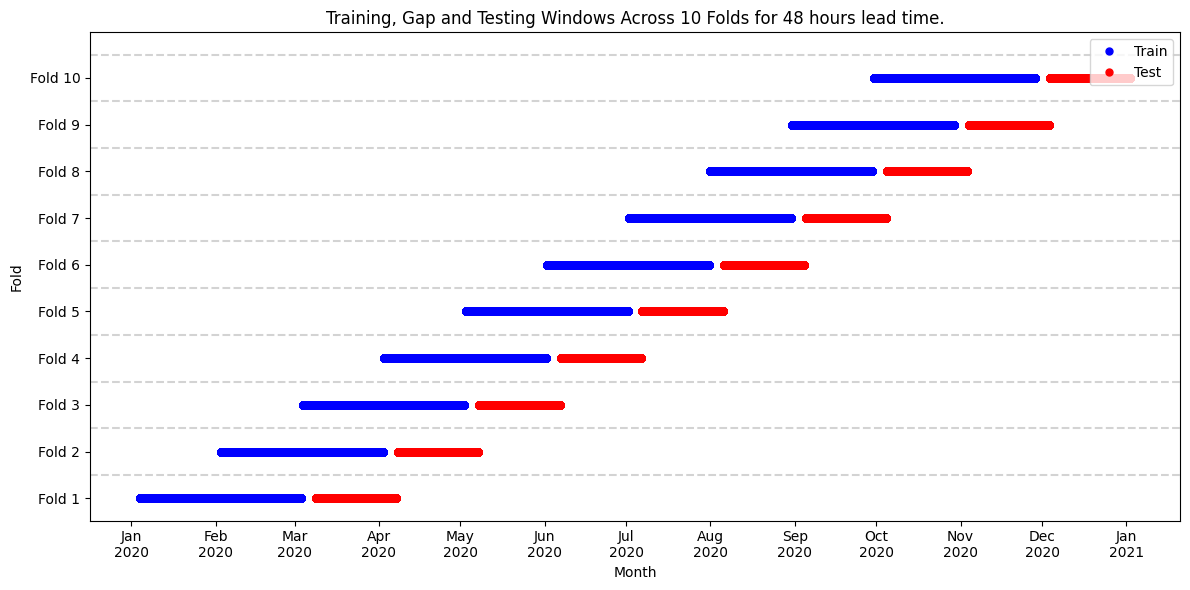

Fold 1:
  mse: 15209.0927734375
  PiggyCast: area weighted rmse: 76.76277746972184
  graphcast: area weighted rmse: 72.89521727913798
  pangu: area weighted rmse: 81.53557879205798
  neuralgcm: area weighted rmse: 61.32865112702906
  ifshres: area weighted rmse: 77.69317822238818
Fold 2:
  mse: 9210.8720703125
  PiggyCast: area weighted rmse: 66.86750469041097
  graphcast: area weighted rmse: 70.89595346008002
  pangu: area weighted rmse: 80.0969255422813
  neuralgcm: area weighted rmse: 62.04284877201307
  ifshres: area weighted rmse: 76.40121126092066
Fold 3:
  mse: 7203.16845703125
  PiggyCast: area weighted rmse: 64.48324208575639
  graphcast: area weighted rmse: 70.5749420055696
  pangu: area weighted rmse: 74.76480428843476
  neuralgcm: area weighted rmse: 61.50660557160111
  ifshres: area weighted rmse: 74.98039911101573
Fold 4:
  mse: 10929.08203125
  PiggyCast: area weighted rmse: 74.77433859172058
  graphcast: area weighted rmse: 67.91825353957019
  pangu: area weighted rmse:

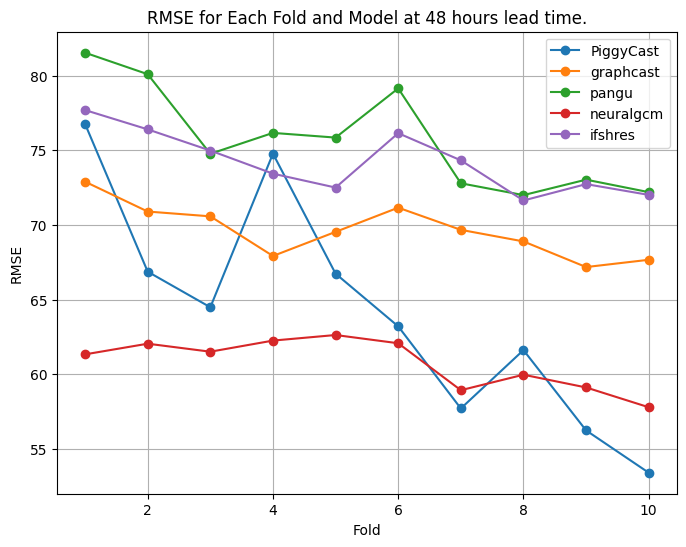

In [ ]:
# @title Training and Evaluation Loop - Longer time series split
# This section initializes the XGBoost regressor and sets up the time series cross-validation.

# Initialize xgb regressor
xgb = xgboost.XGBRegressor(random_state=42, device="cuda")

# Calculate Cross-Validation using 10 folds
cv_timeseries = TimeSeriesSplit(n_splits=10, max_train_size=32 * 64 * 2 * 60,
                                test_size= 32 * 64 * 2 * 30, gap=32 * 64 * 2 * 5)

# Lead Times
lead_times=[48]

nested_scores = {} # Nested scores for each lead time
rmse_results = {} # rmse results for each lead time, models

for lead_time in lead_times:
  print(f"======Lead time: {lead_time}========")

  df_filtered = data_per_lead_time(full_df,lead_time)

  X = df_filtered[[f"graphcast_lt{lead_time}", f"pangu_lt{lead_time}",
                   f"neuralgcm_lt{lead_time}",
                  #  f"keisler_lt{lead_time}",
                   f"ifshres_lt{lead_time}", "longitude", "latitude"]]
  y = df_filtered["era5"]
  area_weight = df_filtered["area_weight"]

  print(f"Shape of x :{X.shape}")
  print(f"Shape of y : {y.shape}")

  # Nested Scores
  nested_score = cross_validate(xgb, X=X, y=y, cv=cv_timeseries,
                              scoring=('neg_mean_squared_error', 'r2'),
                              params={'sample_weight': area_weight}
                              )
  nested_scores[lead_time] = nested_score

  # Cross validation plot
  cross_validation_plot(df_filtered, cv_timeseries, lead_time)

  # RMSE
  rmse_result = train_and_evaluate(xgb, cv_timeseries,X,y, area_weight, lead_time)
  rmse_results[lead_time] = rmse_result

  # RMSE plots per model
  rmse_per_fold_plot(rmse_result, lead_time)



Train times Min Date: 2020-01-04 00:00:00 Train times Max Date:2020-03-03 12:00:00
Test times Min Date: 2020-03-09 00:00:00 Test times Max Date:2020-04-07 12:00:00
Train times Min Date: 2020-02-03 00:00:00 Train times Max Date:2020-04-02 12:00:00
Test times Min Date: 2020-04-08 00:00:00 Test times Max Date:2020-05-07 12:00:00
Train times Min Date: 2020-03-04 00:00:00 Train times Max Date:2020-05-02 12:00:00
Test times Min Date: 2020-05-08 00:00:00 Test times Max Date:2020-06-06 12:00:00
Train times Min Date: 2020-04-03 00:00:00 Train times Max Date:2020-06-01 12:00:00
Test times Min Date: 2020-06-07 00:00:00 Test times Max Date:2020-07-06 12:00:00
Train times Min Date: 2020-05-03 00:00:00 Train times Max Date:2020-07-01 12:00:00
Test times Min Date: 2020-07-07 00:00:00 Test times Max Date:2020-08-05 12:00:00
Train times Min Date: 2020-06-02 00:00:00 Train times Max Date:2020-07-31 12:00:00
Test times Min Date: 2020-08-06 00:00:00 Test times Max Date:2020-09-04 12:00:00
Train times Min 

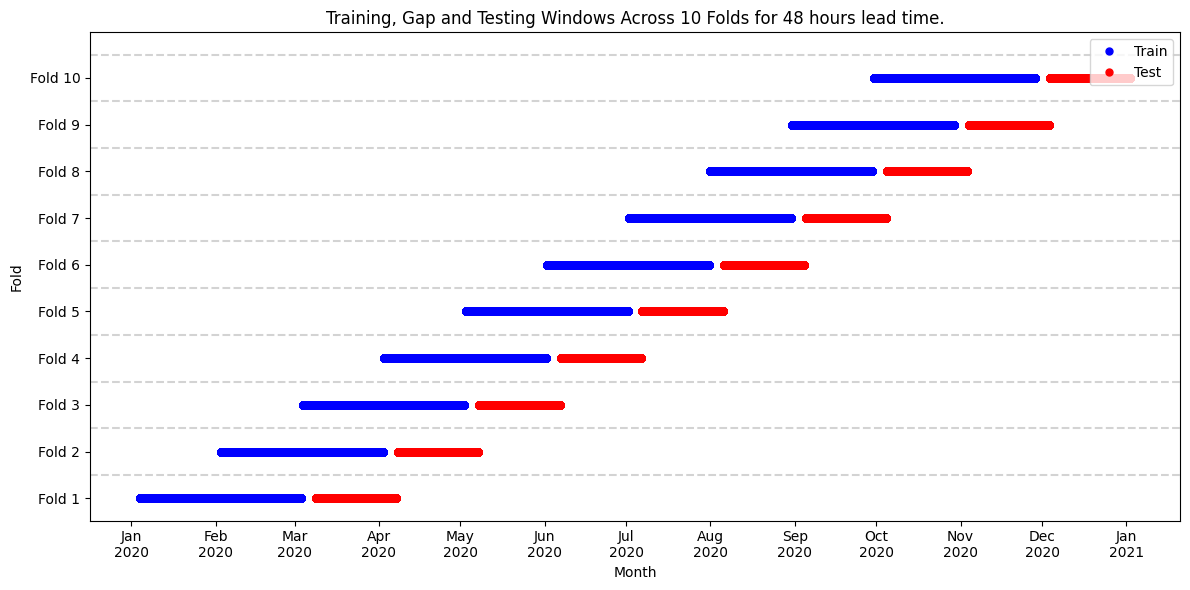

In [ ]:
# @title Cross Validation Plot for Time Series Split
# This section plots the training and testing windows across 10 folds for a specific lead time.
cv_timeseries = TimeSeriesSplit(n_splits=10, max_train_size=32 * 64 * 2 * 60,
                                test_size= 32 * 64 * 2 * 30, gap=32 * 64 * 2 * 5)
cross_validation_plot(df=df_filtered, cv=cv_timeseries, lead_time=48)

In [ ]:
# @title Create Folds for Time Series Cross-Validation
# This section creates folds for time series cross-validation, defining the training, gap, and testing periods for each fold.
import pandas as pd

# Parameters
n_samples = 1_497_088
n_splits = 10
max_train_size = 32 * 64 * 2 * 60  # 245,760
test_size = 32 * 64 * 2 * 30        # 122,880
gap = 32 * 64 * 2 * 5              # 20,480

# Calculate fold boundaries
folds = []
for i in range(n_splits):
    test_end = n_samples - (n_splits - 1 - i) * test_size
    test_start = test_end - test_size
    train_end = test_start - gap
    train_start = max(0, train_end - max_train_size)

    folds.append({
        "Fold": i + 1,
        "Train Start": train_start,
        "Train End": train_end - 1,
        "Gap Start": train_end,
        "Gap End": test_start - 1,
        "Test Start": test_start,
        "Test End": test_end - 1,
        "Train Size": train_end - train_start,
        "Test Size": test_size,
    })

# Convert to DataFrame
folds_df = pd.DataFrame(folds)
folds_df


,Fold,Train Start,Train End,Gap Start,Gap End,Test Start,Test End,Train Size,Test Size
0,1,2048,247807,247808,268287,268288,391167,245760,122880
1,2,124928,370687,370688,391167,391168,514047,245760,122880
2,3,247808,493567,493568,514047,514048,636927,245760,122880
3,4,370688,616447,616448,636927,636928,759807,245760,122880
4,5,493568,739327,739328,759807,759808,882687,245760,122880
5,6,616448,862207,862208,882687,882688,1005567,245760,122880
6,7,739328,985087,985088,1005567,1005568,1128447,245760,122880
7,8,862208,1107967,1107968,1128447,1128448,1251327,245760,122880
8,9,985088,1230847,1230848,1251327,1251328,1374207,245760,122880
9,10,1107968,1353727,1353728,1374207,1374208,1497087,245760,122880
